In [1]:
!pip install pytorch_pretrained_vit

import s3fs
import boto3

import time

from PIL import Image
import numpy as np
import hashlib
import io
import json
import gc
from tqdm import tqdm
import pandas as pd
import os
from collections import Counter

import torch
from pytorch_pretrained_vit import ViT

from torchvision.transforms import v2

from torchvision import models
from torchvision import transforms, models

from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_pretrained_vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11114 sha256=1bcb7983df6a511e8d5350eeb707cda61bc2429368ebbac37527d8e804daa9a8
  Stored in directory: /home/ec2-user/.cache/pip/wheels/2d/46/ad/12007be9d377d0fbf27ef75b6e47ed92832ab6b70dbf004b6f
Successfully built pytorch_pretrained_vit


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [3]:
def init_clients():
    return boto3.client("s3"), s3fs.S3FileSystem()

boto3_s3, s3fs_ = init_clients()

In [4]:
def read_zoom_in():
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv('ZOOMIN.csv')
    del df['Unnamed: 0']
    df['label'] = [8 if x == 5 else x for x in df['label']]

    train_x, test_x, train_y, test_y = train_test_split(df['img_path'], df['label'], test_size=0.3, random_state=42,stratify=df['label'])
    train_x, test_x, train_y, test_y =  train_x[:4000], test_x[:1000], train_y[:4000], test_y[:1000]
    return np.array(train_x), np.array(test_x), np.array(train_y), np.array(test_y)

def read_csv_file():
    df = pd.read_csv('compcars-angle.csv')
    del df['Unnamed: 0']
    train_x, test_x, train_y, test_y = train_test_split(df['img_path'], df['label'], test_size=0.3, random_state=42, stratify=df['label'])
    train_x, test_x, train_y, test_y = train_x[:12000], test_x[:3661], train_y[:12000], test_y[:3661]
    train_x_2, test_x_2, train_y_2, test_y_2 = read_zoom_in()
    train_x = np.concatenate((train_x, train_x_2))
    train_y = np.concatenate((train_y, train_y_2))
    test_x = np.concatenate((test_x, test_x_2))
    test_y = np.concatenate((test_y, test_y_2))
    return np.array(train_x), np.array(test_x), np.array(train_y), np.array(test_y)



In [5]:
def total_data():
    with open('front.json', 'r') as file:
        front = json.load(file)
    with open('rear.json', 'r') as file:
        rear = json.load(file)
    with open('side_lr.json', 'r') as file:
        side = json.load(file)
    with open('rear_lr.json', 'r') as file:
        rear_lr = json.load(file)
    with open('front_lr.json', 'r') as file:
        front_lr = json.load(file)
    new_data = front
    new_data.update(rear)
    new_data.update(side)
    new_data.update(rear_lr)
    new_data.update(front_lr)
    x = list(new_data.keys())
    y = list(new_data.values())
    y = [2 if x == 6 else x for x in y]
    y = [3 if x == 7 else x for x in y]
    y = [4 if x == 8 else x for x in y]
    y = [5 if x == 9 else x for x in y]
    y = [6 if x == 10 else x for x in y]
    y = [7 if x == 11 else x for x in y]
    y = [8 if x == 13 else x for x in y]
        
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
    train_x_2, test_x_2, train_y_2, test_y_2 = read_zoom_in()
    train_x = np.concatenate((train_x, train_x_2))
    train_y = np.concatenate((train_y, train_y_2))
    test_x = np.concatenate((test_x, test_x_2))
    test_y = np.concatenate((test_y, test_y_2))
    return train_x, test_x,train_y,test_y

In [6]:
def preprocess_image(image_bytes, byte=True):
    # Open the image as bytes
    if byte is True:
        image = Image.open(io.BytesIO(image_bytes))
    if byte is False:
        image = Image.open(image_bytes)
    # Convert to grayscale
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert image to numpy array
    image_np = np.array(image)

    # Convert the numpy array to PyTorch tensor
    image_tensor = torch.tensor(image_np)

    # Convert the tensor to 3D RGB (if it's not already)
    if len(image_tensor.shape) == 2:
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.permute(2, 0, 1)  # Convert HWC to CHW

    # Normalize to [0, 1]
    image_tensor = image_tensor.float() / 255.0

    return image_tensor


def process_duplicates_image_ids(image_paths: list, batch_size: int,
                                 bucket: str, boto_s3: boto3.client("s3"), 
                                 s3fs_: s3fs.S3FileSystem(), target_size=(384, 384)):
    image_tensors = []
    for i in tqdm(range(0, len(image_paths), batch_size), total=len(image_paths)//batch_size, desc='Processing Images'):
        batch_image_paths = image_paths[i:i + batch_size]
        batch_image_tensors = []
        for ad_image in batch_image_paths:
            if ad_image.lower().startswith("dpgos-osdata-boaz-beukers-sandbox"):
                image_path = "/".join(ad_image.split("/")[1:])
                s3_object = boto_s3.get_object(Bucket=bucket, Key=image_path)
                image_bytes = s3_object['Body'].read()
                image_tensor = preprocess_image(image_bytes,True)
                batch_image_tensors.append(image_tensor)
            if os.path.isfile(ad_image) and ad_image.lower().startswith("datasets/"):
                image_tensor = preprocess_image(ad_image,False)
                batch_image_tensors.append(image_tensor)
        # Resize or crop images to the target size before stacking
        batch_image_tensors_resized = [transforms.functional.resize(image, target_size) for image in batch_image_tensors]
        image_tensors.append(torch.stack(batch_image_tensors_resized))

    # Concatenate processed batches
    processed_image_tensors = torch.cat(image_tensors, dim=0)

    # Display the shape and dtype of the tensor
    print("Tensor Shape:", processed_image_tensors.shape)
    print("Tensor Dtype:", processed_image_tensors.dtype)

    return processed_image_tensors

In [7]:
class CustomDataset(Dataset):
    def __init__(self, images, targets, num_classes):
        self.images = images
        self.targets = targets
        self.num_classes = num_classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        # Convert target label to one-hot encoded tensor
        one_hot_target = torch.zeros(self.num_classes)
        one_hot_target[target] = 1

        return image, one_hot_target

def dataloader(train_x, train_y, test_x, test_y,num_classes):
    train_images, val_images, train_targets, val_targets = train_test_split(train_x, train_y, test_size=0.3, random_state=42, stratify=train_y)

    train_dataset = CustomDataset(train_images, train_targets,num_classes)
    val_dataset = CustomDataset(val_images, val_targets,num_classes)
    
    test_dataset = CustomDataset(test_x, test_y,num_classes)

    train_batch_size = 32
    val_batch_size = 32
    test_batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
    
    return train_loader, val_loader, test_loader


In [8]:
def train_trainedVIT(epochs, train_loader, val_loader):
    start_time = time.time()
    model = ViT('B_16_imagenet1k', pretrained=True).to(device)
    for param in model.parameters():
        param.requires_grad = False   
    model.fc = nn.Sequential(
        nn.Linear(768, 9)  
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters())  

    num_epochs = epochs
    train_losses = []
    validation_losses = []

    best_validation_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_loss = 0.0
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, targets).to(device)
                train_loss += val_loss.item()

        train_loss /= len(val_loader)
        validation_loss = val_loss.item()

        train_losses.append(train_loss)
        validation_losses.append(validation_loss)

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            best_model_state = model.state_dict()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {validation_loss}')

    plt.plot(range(1, num_epochs + 1), train_losses, label='Training set')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation set')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and validation loss ViT')
    plt.legend()
    plt.savefig('training_validation_figure.png')
    plt.show()

    torch.save(best_model_state, 'model_ViT_angle_mult.pth')
    end_time = time.time()
    print("Time taken for training:", end_time - start_time, "seconds")

    return best_model_state, model


In [9]:
def test_VIT(best_model_state, model, test_loader):
    start_time = time.time()
    model.load_state_dict(best_model_state)
    model.eval()

    predictions = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            predictions.append(outputs)

    predictions = torch.cat(predictions, dim=0).to(device)

    _, predicted_labels = torch.max(predictions, 1) 

    result = predicted_labels.tolist()
    end_time = time.time()
    print("Time taken for testing:", end_time - start_time, "seconds")
    return result


In [11]:
# def show_matrix(test_y,result,filename=None):
#     print(classification_report(test_y, result))
#     cm = confusion_matrix(test_y, result)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['front','rear','side','front-side','rear-side','zoom-ins'])
#     disp.plot()
#     if filename:
#         plt.savefig(filename)
#     else:
#         plt.show()
def show_matrix(test_y_svm,y_pred,filename=None):
    print(classification_report(test_y_svm, y_pred))
    cm = confusion_matrix(test_y_svm, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['front','rear','front-left','front-right','rear-right','rear-left','side-left','side-right','zoom-in'])
    disp.plot(xticks_rotation=45)
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

In [12]:
train_x, test_x, train_y, test_y = total_data()
Counter(test_y)

Counter({8: 1000,
         2: 964,
         3: 740,
         0: 617,
         5: 570,
         4: 484,
         6: 472,
         1: 464,
         7: 313})

In [13]:
gc.collect()
im = process_duplicates_image_ids(image_paths=train_x, batch_size=100, bucket="dpgos-osdata-boaz-beukers-sandbox", boto_s3=boto3_s3, s3fs_=s3fs_)
im_test = process_duplicates_image_ids(image_paths=test_x, batch_size=100, bucket="dpgos-osdata-boaz-beukers-sandbox", boto_s3=boto3_s3, s3fs_=s3fs_)

Processing Images:   0%|          | 0/147 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Processing Images: 148it [20:28,  8.30s/it]                         


Tensor Shape: torch.Size([14789, 3, 384, 384])
Tensor Dtype: torch.float32


Processing Images: 57it [06:09,  6.49s/it]                        


Tensor Shape: torch.Size([5624, 3, 384, 384])
Tensor Dtype: torch.float32


In [14]:
def main_trainedVIT():
    #train_x, test_x, train_y, test_y = read_csv_file()
    gc.collect()
    #im = process_duplicates_image_ids(image_paths=train_x, batch_size=100, bucket="dpgos-osdata-boaz-beukers-sandbox", boto_s3=boto3_s3, s3fs_=s3fs_)
    #im_test = process_duplicates_image_ids(image_paths=test_x, batch_size=100, bucket="dpgos-osdata-boaz-beukers-sandbox", boto_s3=boto3_s3, s3fs_=s3fs_)
#     for i in range(5):
    train_loader,val_loader,test_loader = dataloader(im,train_y,im_test,test_y,9)
    best_model,model = train_trainedVIT(20,train_loader,val_loader)
    result = test_VIT(best_model,model,test_loader)
    matrix = show_matrix(test_y,result,filename='MULTIANGLE_trainedVIT_results.png')

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth
100%|██████████| 331M/331M [00:00<00:00, 456MB/s] 


Loaded pretrained weights.
Epoch 1/20, Train Loss: 0.6676586148121374, Val Loss: 0.4790761172771454
Epoch 2/20, Train Loss: 0.5884827223184298, Val Loss: 0.3748953640460968
Epoch 3/20, Train Loss: 0.5713532577744491, Val Loss: 0.3651937246322632
Epoch 4/20, Train Loss: 0.5906190256849467, Val Loss: 0.4088900089263916
Epoch 5/20, Train Loss: 0.5734512269925728, Val Loss: 0.30622291564941406
Epoch 6/20, Train Loss: 0.5456218700185954, Val Loss: 0.35957467555999756
Epoch 13/20, Train Loss: 0.5653649161187865, Val Loss: 0.35275590419769287
Epoch 14/20, Train Loss: 0.5558631859666152, Val Loss: 0.27092331647872925
Epoch 20/20, Train Loss: 0.5651449286680428, Val Loss: 0.33803433179855347


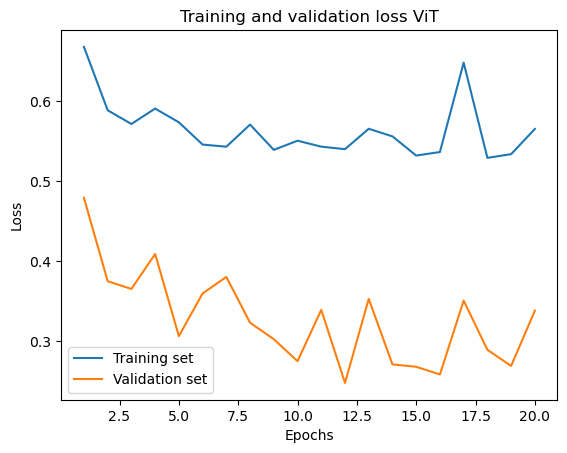

Time taken for training: 10415.456571102142 seconds
Time taken for testing: 187.2345428466797 seconds
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       617
           1       0.98      0.98      0.98       464
           2       0.56      0.90      0.69       964
           3       0.67      0.16      0.26       740
           4       0.48      0.73      0.58       484
           5       0.60      0.28      0.38       570
           6       0.58      0.73      0.64       472
           7       0.45      0.34      0.39       313
           8       0.99      1.00      0.99      1000

    accuracy                           0.71      5624
   macro avg       0.70      0.67      0.65      5624
weighted avg       0.72      0.71      0.68      5624



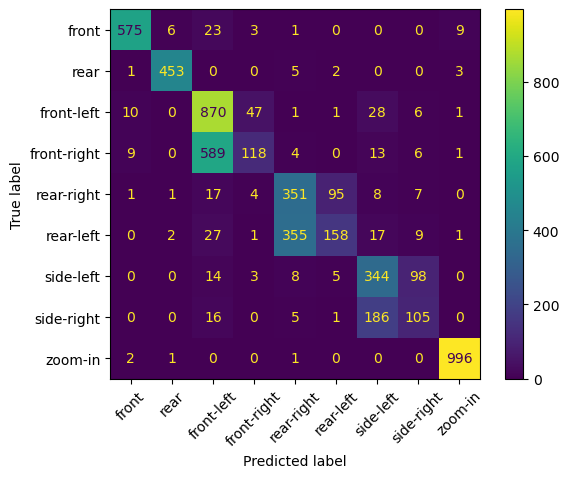

In [ ]:
main_trainedVIT()

In [11]:
def fit_train_embeddings(im_train,train_y):
    start_time = time.time()

    model = ViT('B_16_imagenet1k', pretrained=True).to(device)
    model.eval()
    data_loader = DataLoader(im_train, batch_size=32, shuffle=False)
    embeddings = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            embedding_batch = model(batch)
            embeddings.append(embedding_batch)

    train_embeddings = torch.cat(embeddings, dim=0).cpu().numpy()
    print('Fitting in progress:')
    svm_classifier = SVC(kernel='rbf', random_state=42)
    svm_classifier.fit(train_embeddings, train_y)
    print('Fitting done:')
    end_time = time.time()
    print("Time taken for training:", end_time - start_time, "seconds")
    return svm_classifier

In [12]:
def predict_test_embeddings(im_test,svm_classifier):
    start_time = time.time()
    model = ViT('B_16_imagenet1k', pretrained=True).to(device)
    model.eval()


    data_loader = DataLoader(im_test, batch_size=32, shuffle=False)
    embeddings = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            embedding_batch = model(batch)
            embeddings.append(embedding_batch)

    embeddings_test = torch.cat(embeddings, dim=0).cpu().numpy()
    y_pred = svm_classifier.predict(embeddings_test)
    end_time = time.time()
    print("Time taken for testing:", end_time - start_time, "seconds")
    return y_pred

In [13]:
# train_x, test_x, train_y, test_y = read_csv_file()
train_x, test_x, train_y, test_y = total_data()

gc.collect()
im_train = process_duplicates_image_ids(image_paths=train_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
        boto_s3=boto3_s3,
        s3fs_=s3fs_)
im_test = process_duplicates_image_ids(image_paths=test_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
        boto_s3=boto3_s3,
        s3fs_=s3fs_)

Processing Images:   0%|          | 0/147 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Processing Images: 148it [05:18,  2.15s/it]                         


Tensor Shape: torch.Size([14789, 3, 384, 384])
Tensor Dtype: torch.float32


Processing Images: 57it [01:30,  1.58s/it]                        


Tensor Shape: torch.Size([5624, 3, 384, 384])
Tensor Dtype: torch.float32


In [14]:
def ViT_SVM():
    svm_classifier = fit_train_embeddings(im_train,train_y)
    result = predict_test_embeddings(im_test,svm_classifier)
    show_matrix(test_y,result,filename='ViT_SVM_classifier_angle.png')


Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth
100%|██████████| 331M/331M [00:07<00:00, 48.1MB/s] 


Loaded pretrained weights.
Fitting in progress:
Fitting done:
Time taken for training: 548.3268647193909 seconds
Loaded pretrained weights.
Time taken for testing: 241.23208045959473 seconds
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       617
           1       0.95      0.99      0.97       464
           5       0.99      0.99      0.99      1000
           6       0.52      0.94      0.67       964
           7       0.39      0.01      0.02       740
           8       0.50      0.13      0.20       484
           9       0.53      0.80      0.64       570
          10       0.55      0.92      0.69       472
          11       0.00      0.00      0.00       313

    accuracy                           0.69      5624
   macro avg       0.60      0.63      0.57      5624
weighted avg       0.64      0.69      0.62      5624



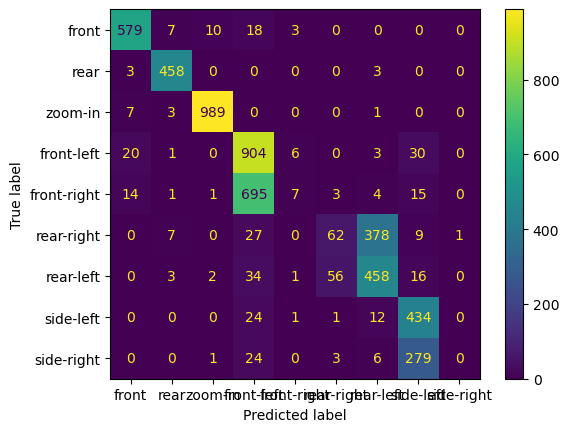

In [15]:
ViT_SVM()